In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
train_dataset_path = 'train_thainumber'
validation_dataset_path = 'test_thainumber'

In [3]:
IMG_WIDTH = 28
IMG_HEIGHT = 28
BATCH_SIZE = 32 #

In [4]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 300 images belonging to 10 classes.


In [5]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 60 images belonging to 10 classes.


In [6]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : 0
1 : 1
2 : 2
3 : 3
4 : 4
5 : 5
6 : 6
7 : 7
8 : 8
9 : 9


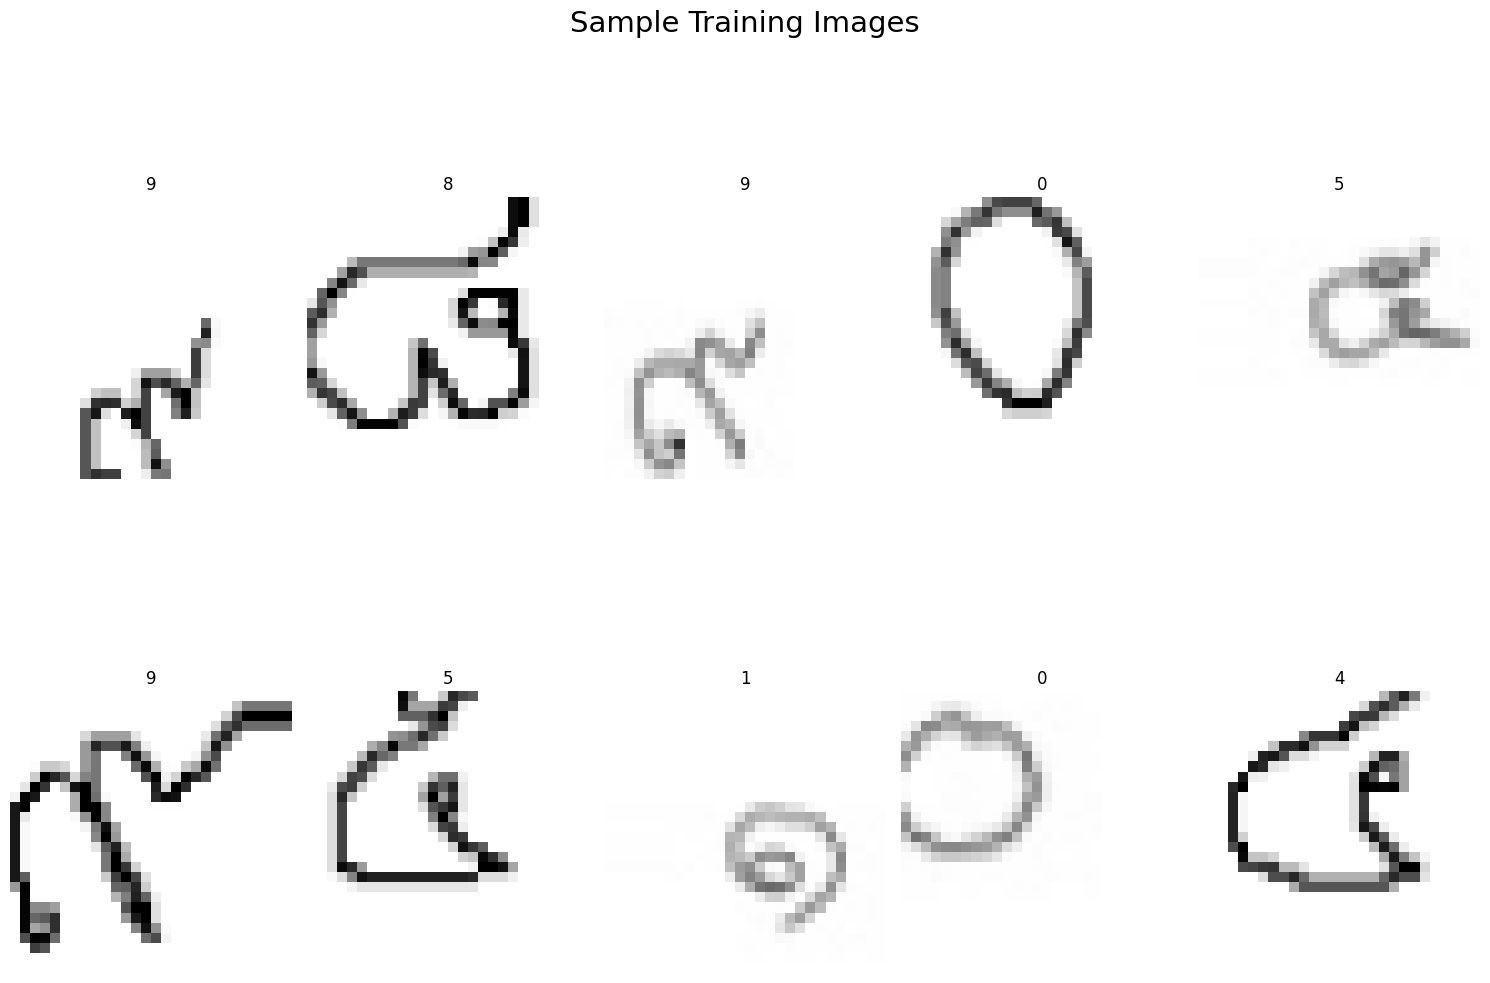

In [7]:
#3. Plotting Sample Training Images
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [11]:
#Create a CNN Model
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=10, activation='softmax')
    ])
    
    return model

In [12]:
cnn_model = create_model()

In [13]:
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 24, 24, 128)       9728      
                                                                 
 activation_3 (Activation)   (None, 24, 24, 128)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 128)      0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 12, 12, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 64)        73792     
                                                                 
 activation_4 (Activation)   (None, 10, 10, 64)       

In [14]:
#a. Reduce Learning Rate on Plateau
#Is used to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [15]:
#Defining the Optimizer
optimizer = Adam(learning_rate=0.001)

In [16]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [20]:
#Training the Model
history = cnn_model.fit(train_generator, epochs=100, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/100
10/10 - 0s - loss: 1.2968 - accuracy: 0.5933 - val_loss: 1.3686 - val_accuracy: 0.5333 - lr: 3.1623e-05 - 432ms/epoch - 43ms/step
Epoch 2/100
10/10 - 0s - loss: 1.3554 - accuracy: 0.5667 - val_loss: 1.3389 - val_accuracy: 0.5667 - lr: 3.1623e-05 - 368ms/epoch - 37ms/step
Epoch 3/100
10/10 - 0s - loss: 1.3400 - accuracy: 0.5467 - val_loss: 1.3149 - val_accuracy: 0.5667 - lr: 3.1623e-05 - 369ms/epoch - 37ms/step
Epoch 4/100
10/10 - 0s - loss: 1.2982 - accuracy: 0.5767 - val_loss: 1.2997 - val_accuracy: 0.5667 - lr: 3.1623e-05 - 382ms/epoch - 38ms/step
Epoch 5/100
10/10 - 0s - loss: 1.3158 - accuracy: 0.5767 - val_loss: 1.2801 - val_accuracy: 0.5833 - lr: 3.1623e-05 - 374ms/epoch - 37ms/step
Epoch 6/100
10/10 - 0s - loss: 1.2789 - accuracy: 0.5667 - val_loss: 1.2486 - val_accuracy: 0.6333 - lr: 3.1623e-05 - 373ms/epoch - 37ms/step
Epoch 7/100
10/10 - 0s - loss: 1.3303 - accuracy: 0.5433 - val_loss: 1.2282 - val_accuracy: 0.6000 - lr: 3.1623e-05 - 378ms/epoch - 38ms/step
Epoch 

In [21]:
#Plotting the Model Metrics
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

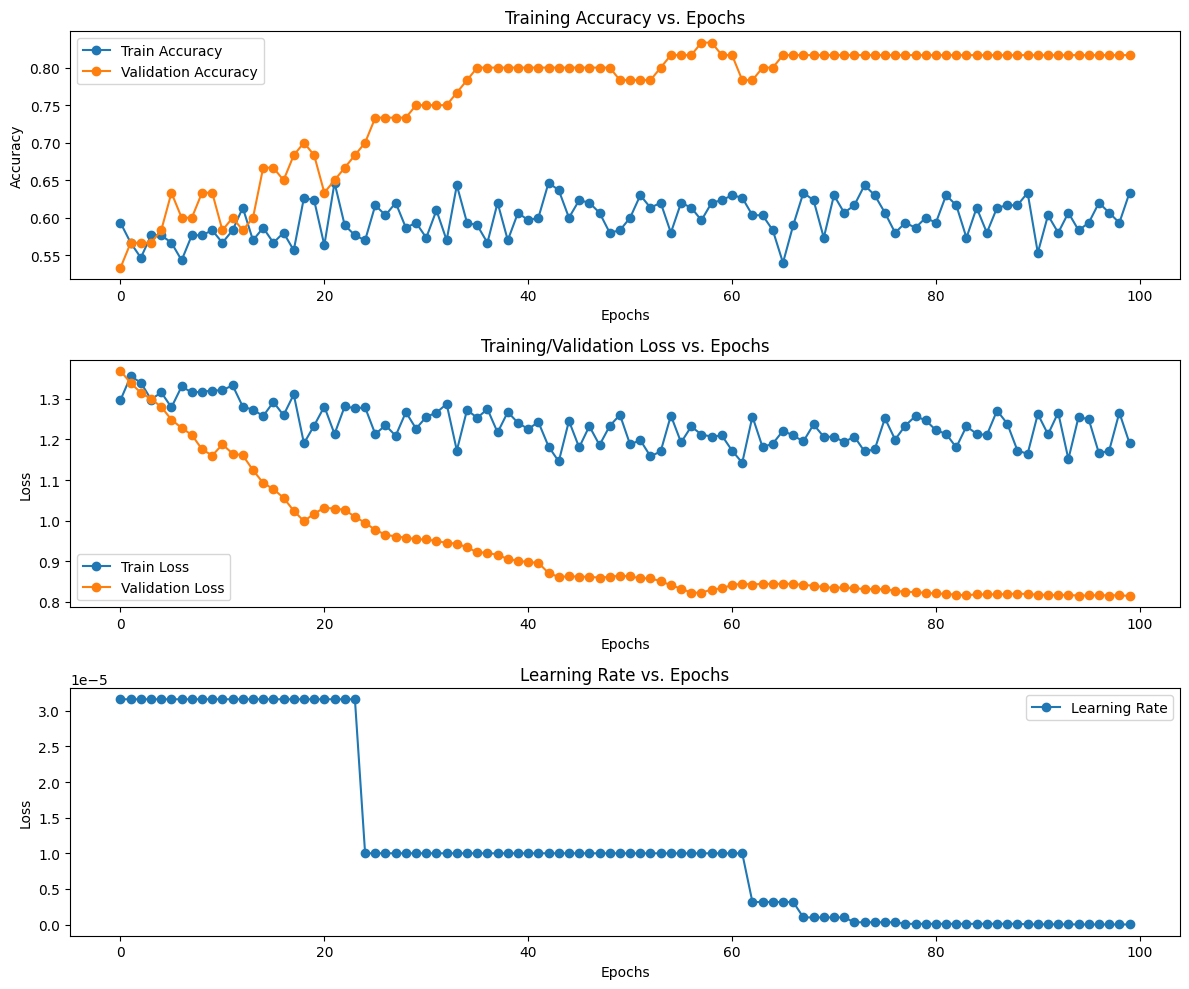

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [24]:
#Testing the Model on Test Set
test_dataset = 'test_thainumber'

In [25]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 60 images belonging to 10 classes.


In [26]:
#Model Prediction on the Test Dataset
predictions = cnn_model.predict(test_generator)

2/2 [==============================] - 0s 13ms/step


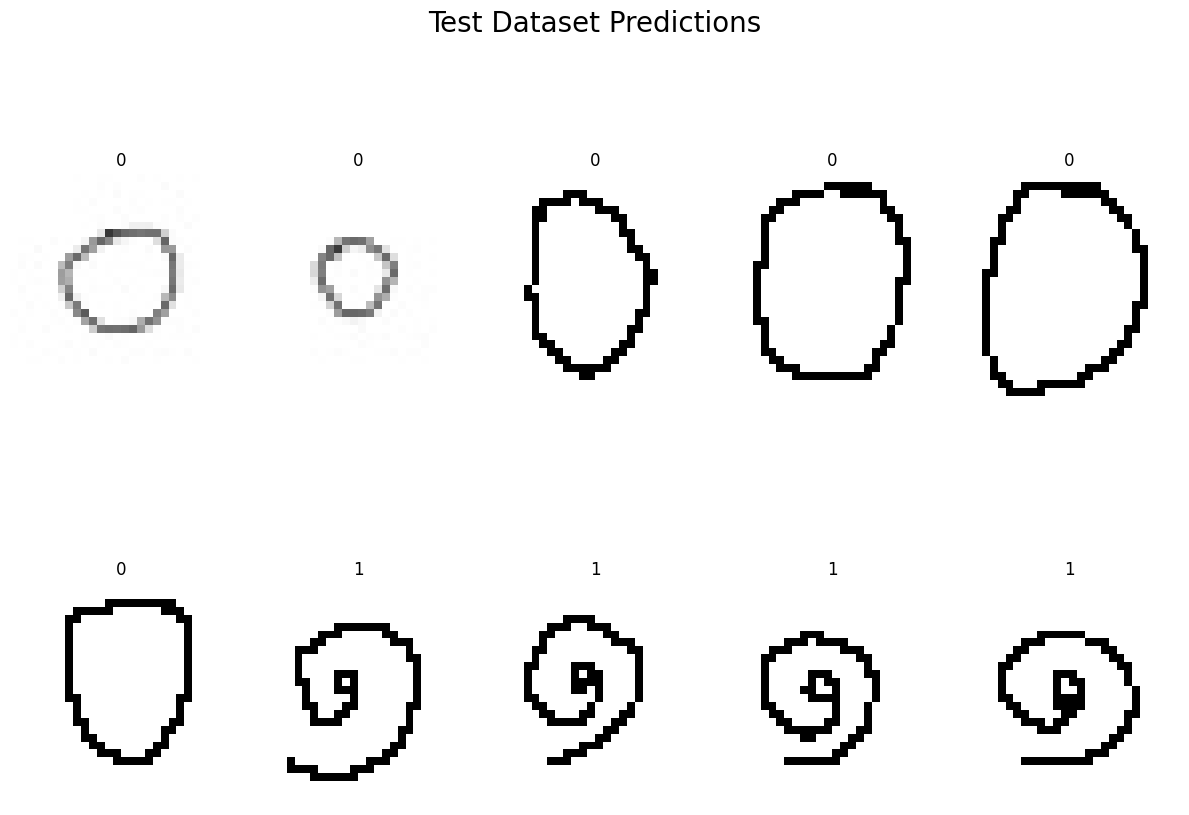

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [29]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

2/2 [==============================] - 0s 13ms/step - loss: 0.8141 - accuracy: 0.8167


In [30]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.8140583038330078
Test Accuracy: 0.8166666626930237


In [31]:
#Plotting the Classification Metrics
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

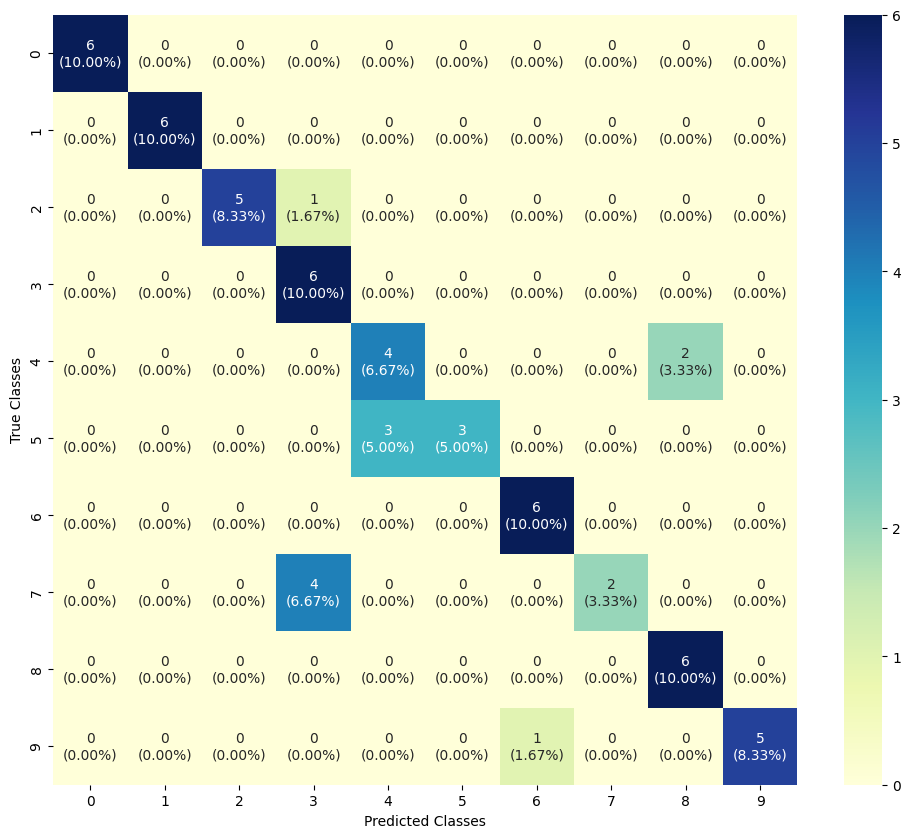

In [33]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(10, 10)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [34]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      0.83      0.91         6
           3       0.55      1.00      0.71         6
           4       0.57      0.67      0.62         6
           5       1.00      0.50      0.67         6
           6       0.86      1.00      0.92         6
           7       1.00      0.33      0.50         6
           8       0.75      1.00      0.86         6
           9       1.00      0.83      0.91         6

    accuracy                           0.82        60
   macro avg       0.87      0.82      0.81        60
weighted avg       0.87      0.82      0.81        60



In [35]:
#Wrong Predictions
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [36]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

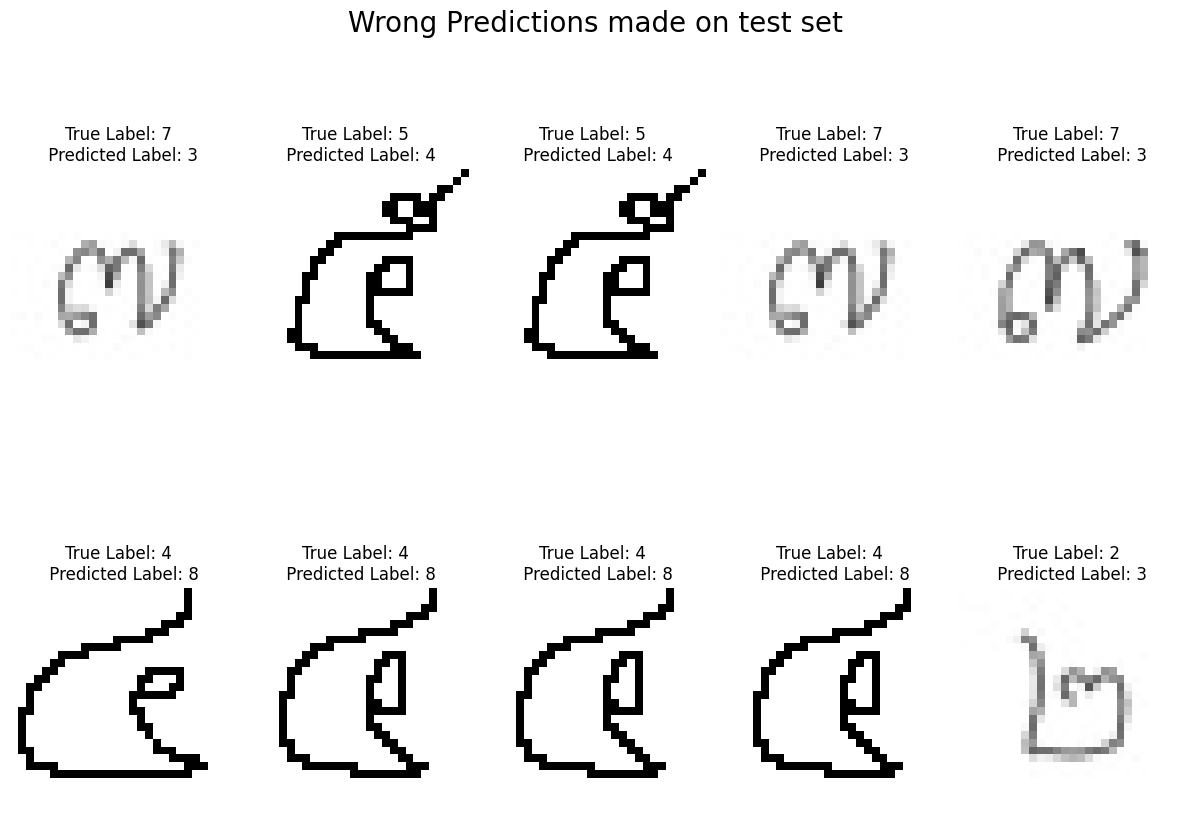

In [37]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()